## Imports and generic functions

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_extra.cluster import KMedoids
import copy

In [ ]:
red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
# green = (0.31, 1, 0.34) # (79, 255, 87)
green = (0.122, 00.816, 0.51) # (31, 208, 130)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)
cgreen = (0.57254902, 0.7254902 , 0.51372549) # (146, 185, 131)
cblue = (0.70196078, 0.83137255, 1) # (179, 212, 255)

top_domain = 53.32 # 90% quantile

def get_hydro_opt(d, lh, ls, lb, max_elec):
    # Get optimal adjustment at given balancing prices
    if ls > lh:
        return 0
    elif lb < lh:
        return max_elec
    else:
        return np.minimum(max_elec, np.maximum(0, d))

def import_consts(negative_prices=False):
    # import data and set constants
    all_data = pd.read_csv("./data/2020_data.csv")
    prices_B = np.maximum(all_data["UP"].to_numpy(),0)
    prices_S = np.maximum(all_data["DW"].to_numpy(),0)
    prices_F = np.maximum(all_data["forward_RE"].to_numpy(),0)
    prices_forecast = np.maximum(all_data["forward_FC"].to_numpy(), 0)

    max_elec = 10
    max_wind = 10
    nominal_wind = 10
    min_production = 50


    features = all_data.loc[:, ["Offshore DK2", "Offshore DK1", "Onshore DK2", "Onshore DK1", "production_FC"]]
    features["forward"] = prices_F
    features_red = all_data.loc[:, ["production_FC"]]
    features_red["forward"] = prices_F
    realized = all_data.loc[:, "production_RE"].to_numpy()
    realized *= nominal_wind

    # forecast_production = all_data.loc[:, "production_FC"].to_numpy() * nominal_wind
    fm_df = pd.read_csv("./results/2020_fm.csv")
    forecast_production = fm_df.loc[:,"forecast_production"]

    price_H = 35.199999999999996
    penalty = np.quantile(prices_B, 0.95) # 95% quantile of deficit_settle price over all 2 years
    # penalty = 2 * price_H
    # penalty = np.max(prices_B) # Something HIGHER is needed apparently

    return (
        prices_B,
        prices_S,
        prices_F,
        prices_forecast,
        features,
        features_red,
        realized,
        price_H,
        max_elec,
        nominal_wind,
        penalty,
        min_production,
        forecast_production
    )

def get_forward_1(qF, features, t, fm):
    # Get forward market bid for model with 1 parameter per feature (General architecture)

    if fm:
        return np.sum([qF.iloc[0, i]*features[i][t] for i in range(len(features))]) + qF.iloc[0, -1]
    else:
        return np.sum([qF.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[0, -1]

def get_forward_24(qF, features, t, fm):
    # Get forward market bid for model with 24 parameters per feature (Hourly architecture)
    hour_of_day = (t % 24)
    if fm:
        return np.sum([qF.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qF.iloc[hour_of_day, -1]
    else:
        return np.sum([qF.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[hour_of_day, -1]


def get_hydro_1(qH, features, max_elec, t, fm):
    # Get hydrogen schedule for model with 1 parameter per feature (General architecture)
    
    if fm:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features[i][t] for i in range(len(features))]) + qH.iloc[0, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[0, -1]))

def get_hydro_24(qH, features, max_elec, t, fm):
    # Get hydrogen schedule for model with 24 parameters per feature (Hourly architecture)
    hour_of_day = (t % 24) 
    if fm:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qH.iloc[hour_of_day, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[hour_of_day, -1]))

def get_scaled_objs(list_of_results):
    # Get total revenue scaled to millions
    return [np.sum(result['obj'])/(1e6) for result in list_of_results]

def get_remaining_planned_hydro(df, features, max_elec, i):
    # Get the remaining amount of hydrogen scheduled in a given hour
    hour_of_day = (i % 24) 
    if (hour_of_day == 23):
        return 0
    remaining_hours = 23-hour_of_day
    return np.sum([get_hydro_24(df, features, max_elec, i+j)  for j in range(1, remaining_hours)])

#---------general and hourly evaluation loops

def test_initial_plan(df_f, df_h, idx_start, idx_end, general=False, fm=False, reduced_features=False):
    # Perform complete evaluation for general(general) and hourly models in a given time period : GA, HA
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    ups = []
    dws = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if (general):
            if fm:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, fm)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_1(df_f, features, i, fm)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, fm)
                    
        else:
            if fm:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, fm)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_24(df_f, features, i, fm)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, fm)
                    
                
            
        forward_bid = np.minimum(forward_bid, nominal_wind)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)

        daily_count += h_prod

        settlementd = realized[i] - forward_bid - h_prod

        up = np.maximum(-settlementd, 0)
        dw = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + dw * prices_S[i]
            - up * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        ups.append(up)
        dws.append(dw)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "up": ups,
        "dw": dws,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end, general=False, fm=False, reduced_features=False, weekly=False):
    # Perform complete evaluation for general(general) and hourly models with retraining in a given time period : GAR, HAR (not included in report)
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    ups = []
    dws = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')


        if fm:
            df_f = df_retrained[[f"qF{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (general):
            if fm:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, fm)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_1(df_f, features, i, fm)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, fm)
                    
        else:
            if fm:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, fm)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_24(df_f, features, i, fm)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, fm)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        settlementd = realized[i] - forward_bid - h_prod

        up = np.maximum(-settlementd, 0)
        dw = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + dw * prices_S[i]
            - up * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        ups.append(up)
        dws.append(dw)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "up": ups,
        "dw": dws,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_fixed(forward, hydrogen, idx_start, idx_end):
    # Perform complete evaluation for "deterministic with all bids accepted" or "hindsight" models, where the forward bids and hydrogen schedules are fixed by an optimization problem
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    ups = []
    dws = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = forward[i]
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        settlementd = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        up = np.maximum(-settlementd, 0)
        dw = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + dw * prices_S[t]
            - up * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        ups.append(up)
        missing_productions.append(missing_production)
        missing_production = 0
        dws.append(dw)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "up": ups,
        "dw": dws,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results

def test_det(forward, hydrogen, idx_start, idx_end):
    # Perform complete evaluation for deterministic model with 5€/MW buffer in forward bids
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    ups = []
    dws = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if forward[i] >= 0:
            if prices_F[t] > (prices_forecast[t] - 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        else:
            if prices_F[t] < (prices_forecast[t] + 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        
        
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        settlementd = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        up = np.maximum(-settlementd, 0)
        dw = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + dw * prices_S[t]
            - up * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        ups.append(up)
        missing_productions.append(missing_production)
        missing_production = 0
        dws.append(dw)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "up": ups,
        "dw": dws,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results


def test_price_domain(df, idx_start, idx_end, general=False, fm=False, reduced_features=False):
    # Perform complete evaluation for general(general) and hourly models with price domains in a given time period : GAPD, HAPD
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    ups = []
    dws = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0
    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0
            
        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if fm:
            df_f = df[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

        if (general):
            if fm:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, fm)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_1(df_f, features, i, fm)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, fm)   
        else:
            if fm:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, fm)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_24(df_f, features, i, fm)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, fm)
                    
            
        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        settlementd = realized[i] - forward_bid - h_prod

        up = np.maximum(-settlementd, 0)
        dw = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + dw * prices_S[i]
            - up * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        ups.append(up)
        dws.append(dw)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "up": ups,
        "dw": dws,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, general=False, fm=False, reduced_features=False, weekly=False):
    # Perform complete evaluation for general(general) and hourly models with price domains and retraining in a given time period : GAPDR, HAPDR
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    ups = []
    dws = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')

        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if fm:
            df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (general):
            if fm:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, fm)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_1(df_f, features, i, fm)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, fm)
                    
        else:
            if fm:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, fm)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_24(df_f, features, i, fm)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, fm)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        settlementd = realized[i] - forward_bid - h_prod

        up = np.maximum(-settlementd, 0)
        dw = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + dw * prices_S[i]
            - up * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        ups.append(up)
        dws.append(dw)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "up": ups,
        "dw": dws,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results


def apply_upwards_adj(results_to_copy, idx_start, idx_end, printing=False):
    # Perform complete evaluation for upwards adjustment performed on a given model
    results = copy.deepcopy(results_to_copy) 
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    ups = []
    dws = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        else:
            h_adj = h_prod
        
        daily_count += h_adj
        settlementd = realized[t] - forward_bid - h_adj
        up = np.maximum(-settlementd, 0)
        dw = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + dw * prices_S[t]
            - up * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        ups.append(up)
        dws.append(dw)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "up": ups,
        "dw": dws,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_up_and_dw_adj(results_to_copy, idx_start, idx_end, printing=False):
    # Perform complete evaluation for upwards and downwards adjustment performed on a given model
    results = copy.deepcopy(results_to_copy) 
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    ups = []
    dws = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)
        
        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        # elif (prices_S[t] > penalty):
        #     h_adj = 0
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                # remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(remaining_hours+1)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted:
                h_adj = opt_h
            else:
                h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                if printing:
                    print(f"i={i}, t={t}, hod={hour_of_day}")
                    print(f"planned={remaining_planned}, produced={daily_count}")
                    print(f"surplus={surplus}, wanted={wanted}")
                    print(f"Original prod: {h_prod}, Resulting prod: {h_adj}")
        
        daily_count += h_adj
        settlementd = realized[t] - forward_bid - h_adj
        up = np.maximum(-settlementd, 0)
        dw = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + dw * prices_S[t]
            - up * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        ups.append(up)
        dws.append(dw)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "up": ups,
        "dw": dws,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_risky_policy(results_to_copy, idx_start, idx_end, printing=False):
    # Perform complete evaluation for postponing adjustment performed on a given model
    results = copy.deepcopy(results_to_copy)
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    ups = []
    dws = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            h_prod = opt_h
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted or hour_of_day == 23:
                h_adj = opt_h
            else:
                # Postpone production to later time with low forward price
                forward_prices_remaining = copy.deepcopy(prices_F[t:t+(23-hour_of_day)])
                while wanted > 0:
                    preffered_idx = np.argmin(forward_prices_remaining)
                    price_to_remove = forward_prices_remaining[preffered_idx]
                    if (prices_B[t] < price_to_remove):
                        # If it is cheaper to buy now than we expect it to be later, don't change
                        h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                        break
                    else:
                        free_turn_up = max_elec - results['h_prod'][i+preffered_idx]
                        if (free_turn_up >= wanted):
                            results['h_prod'][i+preffered_idx] += wanted
                            h_adj = opt_h
                            break
                        else:
                            # Turn up as much as much as possible at cheaper later hour
                            results['h_prod'][i+preffered_idx] = max_elec
                            # Reduce the amount we still want accordingly
                            wanted -= free_turn_up
                            # Make the later price unused
                            forward_prices_remaining[preffered_idx] = 9999
                            # Recalculate how much we have in surplus (larger now because we turned up)
                            if (hour_of_day == 23):
                                remaining_planned = 0
                            else:
                                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                            surplus = daily_count + remaining_planned - min_production


        daily_count += h_prod
        settlementd = realized[t] - forward_bid - h_prod
        up = np.maximum(-settlementd, 0)
        dw = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + dw * prices_S[t]
            - up * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        ups.append(up)
        dws.append(dw)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "up": ups,
        "dw": dws,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results



(prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

month = 30*24
year = 8760
idx_start = len(prices_F) - year
idx_end = len(prices_F)

## Testing the models

#### Deterministic and hindsight

In [4]:
#-----------Deterministic
df_det = pd.read_csv("./results/2020/deterministic.csv")

result_det = test_fixed(df_det.loc[:, 'forward bid'], df_det.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Deterministic model: {np.sum(result_det['obj'])}")
# Deterministic model: 497157.51979968895

result_det_strict = test_det(df_det.loc[:, 'forward bid'], df_det.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Deterministic model +/- : {np.sum(result_det_strict['obj'])}")


#-----------hindsight
df_opt = pd.read_csv("./results/2020/optimal_everything.csv")

result_opt = test_fixed(df_opt.loc[:, 'forward bid'], df_opt.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Optimal everything: {np.sum(result_opt['obj'])}")


Deterministic model: 1777448.3823934894
Deterministic model +/- : 1708136.0732003595
Optimal everything: 1893219.9725490191


#### General models

##### General

In [ ]:

#--------------------------GENERAL-----------------

def test_general(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        df = pd.read_csv(f"./results/2020/comparing_architecture/{model_name}_mo{i+1}.csv")
        df_f = df[[f"qF{j+1}" for j in range(int(len(df.columns)/2))]]
        df_h = df[[f"qH{j+1}" for j in range(int(len(df.columns)/2))]]
        tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, True, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# # GENERAL For all features 
results_g_all = test_general("GENERAL")

# GENERAL Only forecast and price features 
results_g_rf = test_general("GENERAL_rf", False, True)

# GENERAL Forecast 
results_g_fm = test_general("GENERAL_fm", True)


##### General oracle

In [ ]:
#--------------------------GENERAL-----------------

def test_general_oracle(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2020/comparing_architecture/{model_name}.csv")
    df_f = df[[f"qF{j+1}" for j in range(int(len(df.columns)/2))]]
    df_h = df[[f"qH{j+1}" for j in range(int(len(df.columns)/2))]]
    tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, True, fm, reduced_features)
    results.append(tester_results)
    print(f"Results: {np.sum(tester_results['obj'])}")
    return results

# GENERAL For all features - best was 
results_g_all_oracle = test_general_oracle("GENERAL_ORACLE")

# GENERAL Only forecast and price features - best was 
results_g_rf_oracle = test_general_oracle("GENERAL_rf_ORACLE", False, True)

# GENERAL Forecast model - best was 
results_g_fm_oracle = test_general_oracle("GENERAL_fm_ORACLE", True)


##### General PD

In [ ]:

#--------------------------general_PRICEDOMAIN-----------------

def test_general_pd(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        df = pd.read_csv(f"./results/2020/pricedomains/{model_name}_mo{i+1}.csv")
        tester_results = test_price_domain(df, idx_start, idx_end, True, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# general_PRICEDOMAIN For all features
results_g_all_PD = test_general_pd("general_PRICEDOMAIN")

# general_PRICEDOMAIN Only forecast and price features
results_g_rf_PD = test_general_pd("general_rf_PRICEDOMAIN", False, True)

# general_PRICEDOMAIN Forecast model 
results_g_fm_PD = test_general_pd("general_fm_PRICEDOMAIN", True)



##### General pd Retraining

In [ ]:
#--------------------------general_pricedomain_RETRAINING-----------------

def test_general_pd_retraining(init_filename, model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        cqs_filename = (f"./results/2020/changing_qs_general/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, True, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# general_pricedomain_RETRAINING For all features
s_all_pd_init = f"./results/2020/pricedomains/general_PRICEDOMAIN_mo1.csv"
results_g_all_PD_retrained = test_general_pd_retraining(s_all_pd_init, "general_pricedomain_RETRAINING")

# general_pricedomain_RETRAINING Only forecast and price features
s_rf_pd_init = f"./results/2020/pricedomains/general_rf_PRICEDOMAIN_mo1.csv"
results_g_rf_PD_retrained = test_general_pd_retraining(s_rf_pd_init, "general_rf_pricedomain_RETRAINING", False, True)

# general_pricedomain_RETRAINING For all features
s_fm_pd_init = f"./results/2020/pricedomains/general_fm_PRICEDOMAIN_mo1.csv"
results_g_fm_PD_retrained = test_general_pd_retraining(s_fm_pd_init, "general_forecasted_fm_pricedomain_RETRAINING", True)


#### Hourly models

##### Hourly

In [ ]:

#--------------------------HOURLY-----------------

def test_hourly(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        df = pd.read_csv(f"./results/2020/comparing_architecture/{model_name}_mo{i+1}.csv")
        df_f = df[[f"qF{j+1}" for j in range(int(len(df.columns)/2))]]
        df_h = df[[f"qH{j+1}" for j in range(int(len(df.columns)/2))]]
        tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, False, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# HOURLY For all features 
results_h_all = test_hourly("HOURLY")

# HOURLY Only forecast and price features 
results_h_rf = test_hourly("HOURLY_rf", False, True)

# HOURLY Forecast model 
results_h_fm = test_hourly("HOURLY_fm", True)


##### Hourly oracle

In [ ]:

#--------------------------HOURLY oracle-----------------

def test_hourly_oracle(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2020/comparing_architecture/{model_name}.csv")
    df_f = df[[f"qF{j+1}" for j in range(int(len(df.columns)/2))]]
    df_h = df[[f"qH{j+1}" for j in range(int(len(df.columns)/2))]]
    tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, False, fm, reduced_features)
    results.append(tester_results)
    print(f"result: {np.sum(tester_results['obj'])}")
    return results

# HOURLY For all features 
results_h_all_oracle = test_hourly_oracle("HOURLY_ORACLE")

# HOURLY Only forecast and price features 
results_h_rf_oracle = test_hourly_oracle("HOURLY_rf_ORACLE", False, True)

# HOURLY Forecast model 
results_h_fm_oracle = test_hourly_oracle("HOURLY_fm_ORACLE", True)


##### Hourly PD

In [ ]:

#--------------------------hourly_PRICEDOMAIN-----------------

def test_hourly_pd(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(12):
        df = pd.read_csv(f"./results/2020/pricedomains/{model_name}_mo{i+1}.csv")
        tester_results = test_price_domain(df, idx_start, idx_end, False, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# hourly_PRICEDOMAIN For all features 
results_h_all_PD = test_hourly_pd("hourly_PRICEDOMAIN")

# hourly_PRICEDOMAIN Only forecast and price features 
results_h_rf_PD = test_hourly_pd("hourly_rf_PRICEDOMAIN", False, True)

# hourly_PRICEDOMAIN Forecast model 
results_h_fm_PD = test_hourly_pd("hourly_fm_PRICEDOMAIN", True)


##### Hourly retraining

In [ ]:

def test_hourly_retrained(init_filename, model_name, fm=False, reduced_features=False, weekly=False):
    results = []
    print("\nTesting monthly model ", model_name)
    for i in range(12):
        cqs_filename = (f"./results/2020/changing_qs_hourly/{i+1}_month_training/{model_name}")
        tester_results = test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, fm, reduced_features, weekly)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

m_rf_init = f"./results/2020/comparing_architecture/hourly_rf_mo3.csv"
results_h_rf_retrained = test_hourly_retrained(m_rf_init, "hourly_rf_RETRAINING", False, True)

m_fm_init = f"./results/2020/comparing_architecture/HOURLY_fm_mo3.csv"
results_h_fm_retrained = test_hourly_retrained(m_fm_init, "hourly_fm_RETRAINING", True)


##### Hourly pd Oracle

In [ ]:

#--------------------------hourly_pricedomain_ORACLE-----------------

def test_hourly_pd_oracle(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2020/pricedomains/{model_name}.csv")
    tester_results = test_price_domain(df, idx_start, idx_end, False, fm, reduced_features)
    results.append(tester_results)
    print(f"Result: {np.sum(tester_results['obj'])}")
    return results

# hourly_PRICEDOMAIN For all features 
results_h_all_pd_ORACLE = test_hourly_pd_oracle("hourly_pricedomain_ORACLE")

# hourly_PRICEDOMAIN Only forecast and price features 
results_h_rf_pd_ORACLE = test_hourly_pd_oracle("hourly_rf_pricedomain_ORACLE", False, True)

# hourly_PRICEDOMAIN Forecast model 
results_h_fm_pd_ORACLE = test_hourly_pd_oracle("hourly_fm_pricedomain_ORACLE", True)


##### Hourly pd Retraining

In [ ]:
#--------------------------hourly_pricedomain_RETRAINING-----------------

def test_hourly_pd_retraining(init_filename, model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting monthly model ", model_name)
    for i in range(12):
        cqs_filename = (f"./results/2020/changing_qs_hourly/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results


# hourly_pricedomain_RETRAINING For all features
m_all_pd_init = f"./results/2020/pricedomains/hourly_PRICEDOMAIN_mo1.csv"
results_h_all_PD_retrained = test_hourly_pd_retraining(m_all_pd_init, "hourly_pricedomain_RETRAINING")

# hourly_pricedomain_RETRAINING Only forecast and price features
m_rf_pd_init = f"./results/2020/pricedomains/hourly_rf_PRICEDOMAIN_mo3.csv"
results_h_rf_PD_retrained = test_hourly_pd_retraining(m_rf_pd_init, "hourly_rf_pricedomain_RETRAINING", False, True)

# # hourly_pricedomain_RETRAINING Forecast model
m_fm_pd_init = f"./results/2020/pricedomains/hourly_fm_PRICEDOMAIN_mo3.csv"
results_h_fm_PD_retrained = test_hourly_pd_retraining(m_fm_pd_init, "hourly_fm_pricedomain_RETRAINING", True)



In [ ]:
def printstuff(r1, r2, trange, maxcount=10):
    # To perform detailed investigations of model outputs
    counter = 0
    for i in trange:
        if counter > maxcount:
            break
        if round(r2['obj'][i], 0) < round(r1['obj'][i], 0):
            counter += 1
            t = i+idx_start
            print(f"\ni={i}, fp={prices_F[t]}, sp={prices_S[t]}, bp={prices_B[t]}, realized={realized[t]}, opt_h={get_hydro_opt(realized[t]-r1['forward_bid'][i], price_H, prices_S[t], prices_B[t], max_elec)}")
            print(f"ori: {r1['obj'][i]:.2f}, fb={r1['forward_bid'][i]:.2f}, hprod={r1['h_prod'][i]:.2f}, dw={r1['dw'][i]:.2f}, up={r1['up'][i]:.2f}, missing={r1['missing_production'][i]:.2f}")
            print(f"should-be-better: {r2['obj'][i]:.2f}, fb={r2['forward_bid'][i]:.2f}, hprod={r2['h_prod'][i]:.2f}, dw={r2['dw'][i]:.2f}, up={r2['up'][i]:.2f}, missing={r2['missing_production'][i]:.2f}")

# Test on when model HAPD-FM-2 was different from optimal as example:
# printstuff(results_h_fm_PD_retrained[1], result_opt, range(idx_end-idx_start))


#### Adjustment

In [181]:
def adjust(res):
    # Apply all 3 kinds of adjustment to a model
    res_up = apply_upwards_adj(res, idx_start, idx_end)
    res_up_dw = apply_up_and_dw_adj(res, idx_start, idx_end)
    res_pp = apply_risky_policy(res, idx_start, idx_end)
    return res_up, res_up_dw, res_pp

##### Deterministic adjustment

In [235]:
det_up = apply_upwards_adj(result_det, idx_start, idx_end)
det_up_dw = apply_up_and_dw_adj(result_det, idx_start, idx_end)
det_pp = apply_risky_policy(result_det, idx_start, idx_end)
print("Original: ", np.sum(result_det['obj']))
print("Upwards adj: ", np.sum(det_up['obj']))
print("Up + dw adj: ", np.sum(det_up_dw['obj']))
print("Postponing adj: ", np.sum(det_pp['obj']))

det_strict_up = apply_upwards_adj(result_det_strict, idx_start, idx_end)
det_strict_up_dw = apply_up_and_dw_adj(result_det_strict, idx_start, idx_end)
det_strict_pp = apply_risky_policy(result_det_strict, idx_start, idx_end)
print("Original: ", np.sum(result_det_strict['obj']))
print("Upwards adj: ", np.sum(det_strict_up['obj']))
print("Up + dw adj: ", np.sum(det_strict_up_dw['obj']))
print("Postponing adj: ", np.sum(det_strict_pp['obj']))

Original:  1777448.3823934894
Upwards adj:  1817067.7687466051
Up + dw adj:  1843621.9554774128
Postponing adj:  1814477.1817892701
Original:  1708136.0732003595
Upwards adj:  1766892.50774372
Up + dw adj:  1840104.9336213805
Postponing adj:  1763557.2141727428


##### General architecture adjustment (GAPD-FM-3)

In [183]:
other_up = apply_upwards_adj(results_g_fm_PD[2], idx_start, idx_end)
other_up_dw = apply_up_and_dw_adj(results_g_fm_PD[2], idx_start, idx_end)
other_pp = apply_risky_policy(results_g_fm_PD[2], idx_start, idx_end)
print("Original: ", np.sum(results_g_fm_PD[2]['obj']))
print("Upwards adj: ", np.sum(other_up['obj']))
print("Up + dw adj: ", np.sum(other_up_dw['obj']))
print("Postponing adj: ", np.sum(other_pp['obj']))

Original:  1733618.2662310118
Upwards adj:  1785918.7894186443
Up + dw adj:  1853417.808933768
Postponing adj:  1787490.688993813


##### Hourly architecture adjustment (HAPD-FM-3)

In [184]:
best_up = apply_upwards_adj(results_h_fm_PD_retrained[2], idx_start, idx_end)
best_up_dw = apply_up_and_dw_adj(results_h_fm_PD_retrained[2], idx_start, idx_end)
best_pp = apply_risky_policy(results_h_fm_PD_retrained[2], idx_start, idx_end)
print("Original: ", np.sum(results_h_fm_PD_retrained[2]['obj']))
print("Upwards adj: ", np.sum(best_up['obj']))
print("Up + dw adj: ", np.sum(best_up_dw['obj']))
print("Postponing adj: ", np.sum(best_pp['obj']))

Original:  1822643.4693045695
Upwards adj:  1829820.273881879
Up + dw adj:  1851354.207196869
Postponing adj:  1828150.934246541


##### Optimal adjustment for HAPD-AF-12

In [275]:
#-----------HAPD-AF-12
df_opt_adj = pd.read_csv("./results/2020/pricedomains/hourly_PRICEDOMAIN_mo12_opt_adj.csv")

result_opt_adj = test_fixed(df_opt_adj.loc[:, 'forward bid'], df_opt_adj.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Optimal adjustment model: {np.sum(result_opt_adj['obj'])}")



Optimal adjustment model: 1853057.2648960734


##### Deterministic investigation

In [ ]:
counter = 0
zero_fb = 0
zero_fb_sum = 0
nonzero_fb = 0
nonzero_fb_sum = 0
n_opt_max = 0
n_opt_min_dev = 0
n_opt_max_sum = 0
n_opt_min_dev_sum = 0
for i, t in enumerate(range(idx_start, idx_end)):
    # if counter > 15:
    #     break
    if (round(det_up['obj'][i], 0) > round(result_det_strict['obj'][i], 0)):
        opt = get_hydro_opt(realized[t] - result_det_strict['forward_bid'][i], price_H, prices_S[t], prices_B[t], max_elec)
        if (opt == max_elec):
            n_opt_max += 1
        else:
            n_opt_min_dev += 1

        if (round(result_det_strict['forward_bid'][i], 0) == 0):
            zero_fb += 1
            zero_fb_sum += det_up['h_prod'][i] - result_det_strict['h_prod'][i]
            if (opt == max_elec):
                n_opt_max_sum += zero_fb_sum
            else:
                n_opt_min_dev_sum += zero_fb_sum
        else:
            nonzero_fb += 1
            nonzero_fb_sum += det_up['h_prod'][i] - result_det_strict['h_prod'][i]
            if (opt == max_elec):
                n_opt_max_sum += nonzero_fb_sum
            else:
                n_opt_min_dev_sum += nonzero_fb_sum

        # print(f"fb={result_det_strict['forward_bid'][i]}, price FC: {prices_forecast[t]}, fp={prices_F[t]}, deficit_settle price: {prices_B[t]}")


non_strict_res = 0
strict_res = 0
non_strict_res_con = 0
strict_res_con = 0
for i, t in enumerate(range(idx_start, idx_end)):
    if (round(result_det_strict['forward_bid'][i], 0) == 0):
        if (result_det['forward_bid'][i] > 0):
            non_strict_res += prices_F[t] * result_det['forward_bid'][i]
            strict_res += prices_S[t] * result_det['forward_bid'][i]
        else:
            non_strict_res_con += prices_F[t] * result_det['forward_bid'][i]
            strict_res_con += prices_B[t] * result_det['forward_bid'][i]


print(zero_fb)
print(zero_fb_sum)
print("non")
print(nonzero_fb)
print(nonzero_fb_sum)
print(f"max #:", n_opt_max)
print(f"min dev #: ", n_opt_min_dev)
print(f"max sum:", n_opt_max_sum)
print(f"min dev sum: ", n_opt_min_dev_sum)
print("Missed from bad forecasts prod: ", non_strict_res - strict_res)
print("Missed from bad forecasts con: ", non_strict_res_con - strict_res_con)

#### Plots

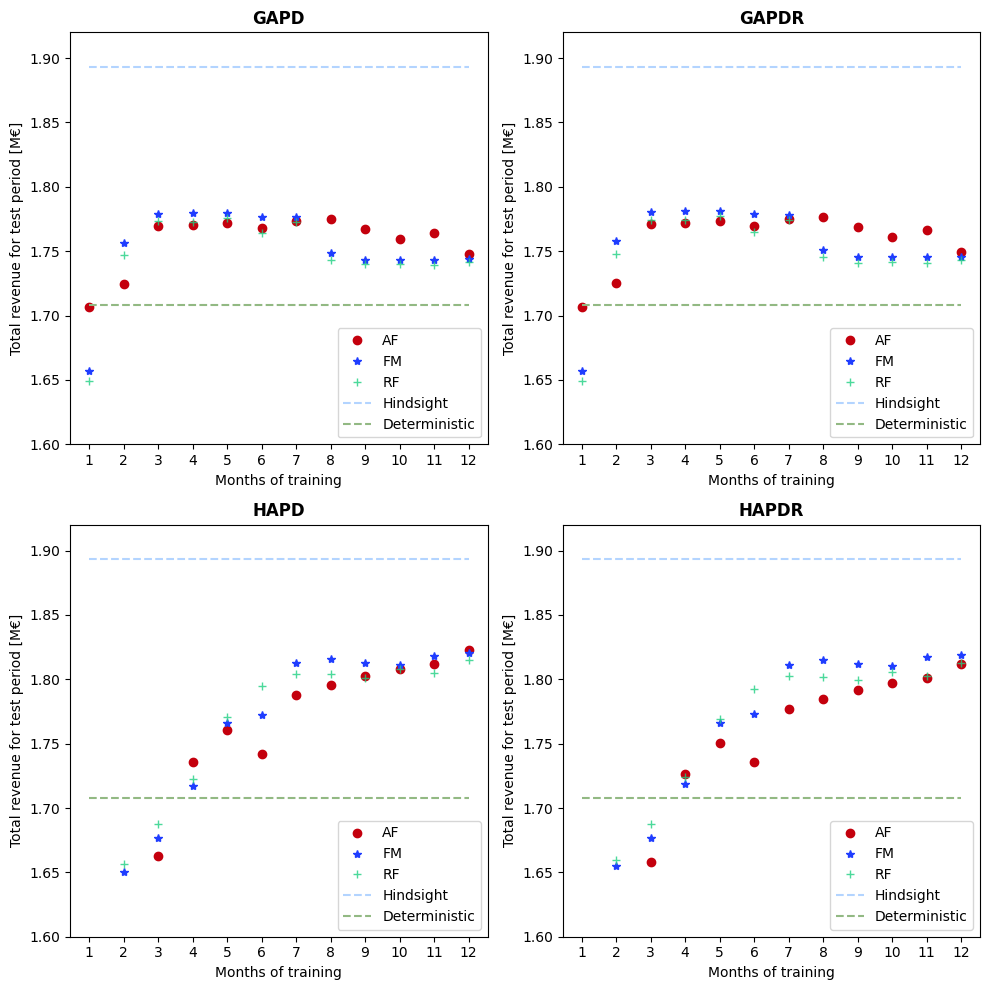

In [25]:
#-------------------OVERVIEW PLOT
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.transforms as mtrans
import matplotlib.markers as markers


#------------------------------------------------------------------------
#-----------------------------------------GA & HA-------------------------
#------------------------------------------------------------------------

def plot_ga_and_ha(save=False):

    results_to_plot = [
        [results_g_all, results_g_rf, results_g_fm],
        [results_h_all, results_h_rf, results_h_fm]
    ]

    plot_titles = [
        "GA",
        "HA"
    ]

    fig, axs = plt.subplots(1,2, figsize=(10,5))
    xs = range(1,13)
    optimals = np.array([np.sum(result_opt['obj'])/(1e6) for _ in xs])
    deterministics = np.array([np.sum(result_det_strict['obj'])/(1e6) for _ in xs])
    for i, result_list in enumerate(results_to_plot):
        axs[i].plot(xs, get_scaled_objs(result_list[0]), 'o', color=red, label="AF")
        axs[i].plot(xs, get_scaled_objs(result_list[2]), '*', color=blue, label="FM")
        axs[i].plot(xs, get_scaled_objs(result_list[1]), '+', color=green, alpha=0.8, label="RF")
        axs[i].plot(xs, optimals, '--', color=cblue, label="Hindsight")
        # axs[idx1, idx2].plot(xs, oracles[i]-0.03, '--', color="grey", label="Oracle")
        axs[i].plot(xs, deterministics, '--', color=cgreen, label="Deterministic")
        axs[i].set_title(plot_titles[i], fontweight="bold")
        axs[i].set_xlabel("Months of training")
        axs[i].set_ylabel("Total revenue for test period [M€]")
        axs[i].set_ylim(0.6, 2)
        axs[i].set_xticks(xs)
        axs[i].legend(loc="lower center")


    fig.tight_layout()
    
    # handles = []


    # af_marker = Line2D([0], [0], label='AF', color=red, marker='o', linestyle='None')
    # fm_marker = Line2D([0], [0], label='FM', color=blue, marker='*', linestyle='None')
    # fp_marker = Line2D([0], [0], label='FP', color=green, marker='+', linestyle='None')

    # hindsight_marker = Line2D([0], [0], label='Hindsight', color=cblue)
    # deterministic_marker = Line2D([0], [0], label='Deterministic', color=cgreen)
    # hindsight_marker.set_linestyle('--')
    # deterministic_marker.set_linestyle('--')
    # handles.append(af_marker) 
    # handles.append(fm_marker) 
    # handles.append(fp_marker) 
    # handles.append(hindsight_marker) 
    # handles.append(deterministic_marker) 
    # fig.legend(handles=handles, bbox_to_anchor=(0.8, 0), ncol=5)
    if save:
        fig.savefig("./pdfs/2020_results_GA_HA.pdf")


#------------------------------------------------------------------------
#-----------------------------------------ALL THE OTHERS-------------------------
#------------------------------------------------------------------------


def plot_others(save=False):

    results_to_plot = [
        [results_g_all_PD, results_g_rf_PD, results_g_fm_PD],
        [results_h_all_PD, results_h_rf_PD, results_h_fm_PD],
        [results_g_all_PD_retrained, results_g_rf_PD_retrained, results_g_fm_PD_retrained],
        [results_h_all_PD_retrained, results_h_rf_PD_retrained, results_h_fm_PD_retrained]
    ]

    plot_titles = [
        "GAPD",
        "HAPD",
        "GAPDR",
        "HAPDR",
    ]

    fig, axs = plt.subplots(2,2, figsize=(10,10))
    xs = range(1,13)
    optimals = np.array([np.sum(result_opt['obj'])/(1e6) for _ in xs])
    deterministics = np.array([np.sum(result_det_strict['obj'])/(1e6) for _ in xs])
    for i, result_list in enumerate(results_to_plot):
        idx2 = int(np.floor((i/2)%3))
        idx1 = int(i%2)
        # print(f"idx1: {idx1}, idx2: {idx2}")
        axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[0]), 'o', color=red, label="AF")
        axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[2]), '*', color=blue, label="FM")
        axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[1]), '+', color=green, alpha=0.8, label="RF")
        axs[idx1, idx2].plot(xs, optimals, '--', color=cblue, label="Hindsight")
        # axs[idx1, idx2].plot(xs, oracles[i]-0.03, '--', color="grey", label="Oracle")
        axs[idx1, idx2].plot(xs, deterministics, '--', color=cgreen, label="Deterministic")
        axs[idx1, idx2].set_title(plot_titles[i], fontweight="bold")
        if idx2 > 0:
            axs[idx1, idx2].legend(loc="lower right")
        else:
            axs[idx1, idx2].legend()
        axs[idx1, idx2].set_xlabel("Months of training")
        axs[idx1, idx2].set_ylabel("Total revenue for test period [M€]")
        axs[idx1, idx2].set_ylim(1.6, 1.92)
        axs[idx1, idx2].set_xticks(xs)

    fig.tight_layout()
    if save:
        fig.savefig("./pdfs/2020_results_OTHERS.pdf")



# plot_ga_and_ha(True)
plot_others()

In [456]:
#--------------------TESTING MISSING PRODUCTION

results_to_plot = [
    # [results_g_all, results_g_rf, results_g_fm],
    # [results_h_all, results_h_rf, results_h_fm],
    # [results_g_all_PD, results_g_rf_PD, results_g_fm_PD],
    # [results_h_all_PD, results_h_rf_PD, results_h_fm_PD],
    [results_g_all_PD_retrained, results_g_rf_PD_retrained, results_g_fm_PD_retrained],
    [results_h_all_PD_retrained, results_h_rf_PD_retrained, results_h_fm_PD_retrained]
]
plot_titles = [
    # "GA",
    # "HA",
    # "GAPD",
    # "HAPD",
    "GAPDR",
    "HAPDR",
]
feature_vector_names = [
    "AF",
    "FM",
    "RF"
]
for i, res_type in enumerate(results_to_plot):
    for j, res_list in enumerate(res_type):
        for k, res in enumerate(res_list):
            total_missing = np.sum(res['missing_production'])
            print(f"Model {plot_titles[i]}-{feature_vector_names[j]}-{k+1} has: {total_missing}")

Model GAPDR-AF-1 has: 315.63164649595296
Model GAPDR-AF-2 has: 12.400139247364116
Model GAPDR-AF-3 has: 47.1213717323029
Model GAPDR-AF-4 has: 57.00090269128934
Model GAPDR-AF-5 has: 63.57589477597304
Model GAPDR-AF-6 has: 71.55501132163586
Model GAPDR-AF-7 has: 71.27610505610095
Model GAPDR-AF-8 has: 61.412081725363535
Model GAPDR-AF-9 has: 54.97900871907095
Model GAPDR-AF-10 has: 25.261739405803326
Model GAPDR-AF-11 has: 62.386028795489324
Model GAPDR-AF-12 has: 7.815970093361102e-14
Model GAPDR-FM-1 has: 63.85537401013219
Model GAPDR-FM-2 has: 63.20681125762505
Model GAPDR-FM-3 has: 53.80745214119299
Model GAPDR-FM-4 has: 53.80745214119266
Model GAPDR-FM-5 has: 68.01048679163492
Model GAPDR-FM-6 has: 61.251068504475185
Model GAPDR-FM-7 has: 62.2707805824314
Model GAPDR-FM-8 has: 2.3862999803144618
Model GAPDR-FM-9 has: 1.4210854715202004e-13
Model GAPDR-FM-10 has: 7.815970093361102e-14
Model GAPDR-FM-11 has: 0.0
Model GAPDR-FM-12 has: 6.394884621840902e-14
Model GAPDR-RF-1 has: 112.

C:\Users\emilh\AppData\Local\Temp\ipykernel_2456\2826125471.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_2456\2826125471.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


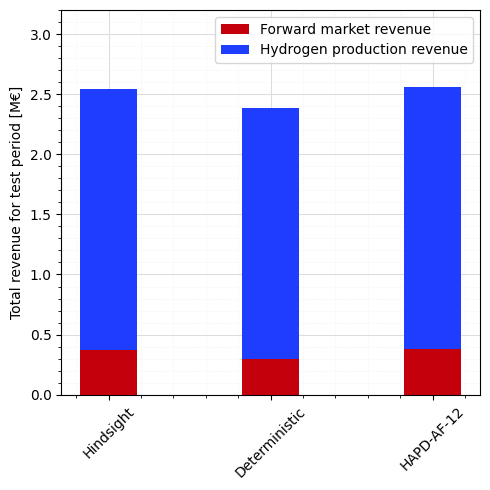

In [16]:
#-------------------REVENUE DISTRIBUTION----------------------
best_res = results_h_all_PD[0]
# oracle_res = results_h_all_pd_ORACLE[0]

strict_det = True
plot_penalties = True
plot_adjustments = False

# forward_opt = np.sum([result_opt['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))])
# forward_det = np.sum([result_det_strict['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))])
# forward_best = np.sum([best_res['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))])
forward_opt = np.sum([result_opt['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))  if (result_opt['forward_bid'][i] > 0)])
forward_det = np.sum([result_det_strict['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))  if (result_det_strict['forward_bid'][i] > 0)])
forward_best = np.sum([best_res['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))  if (best_res['forward_bid'][i] > 0)])

hprod_opt = np.sum([result_opt['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])
hprod_det = np.sum([result_det_strict['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])
hprod_best = np.sum([best_res['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])


def dist_plot():

    if strict_det:
        det_res = result_det_strict
    else:
        det_res = result_det

    # xlabels = ["Hindsight", "Deterministic", "Learned", testname]
    xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12"]
    # xlabels = ["Hindsight", "Deterministic", "95% quantile penalty", "Max penalty"]
    values = np.array([
        forward_opt,
        forward_det,
        forward_best
    ])

    hydrogens = np.array([
        hprod_opt,
        hprod_det,
        hprod_best
    ])

    values *= 1/1e6
    hydrogens *= 1/1e6

    xs = range(len(values))
    width = 0.35
    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.bar(xs, values, width, color=red, label="Forward market revenue")
    ax.bar(xs, hydrogens, width, bottom=values, color=blue, label="Hydrogen production revenue")
    # ax.bar(xs, hydrogens, width, color=blue, label="Hydrogen production revenue")
    # if plot_penalties:
    #     ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
    # if plot_adjustments:
    #     ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xticks(xs)
    ax.set_ylabel("Total revenue for test period [M€]")
    ax.set_ylim(0, 3.2)
    fig.show()
    fig.tight_layout()
    ax.legend()
    print("\n")
    # print(f"Best is {(np.sum(best_res['obj'])-np.sum(other_res['obj']))/(np.sum(other_res['obj']))*100:.2f} % better than {testname}")
    # ax.set_title("2020 Results")
    return fig, ax

fig, ax = dist_plot()

# fig.savefig("./pdfs/rev_dist.pdf")

C:\Users\emilh\AppData\Local\Temp\ipykernel_28472\3140048785.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_28472\3140048785.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


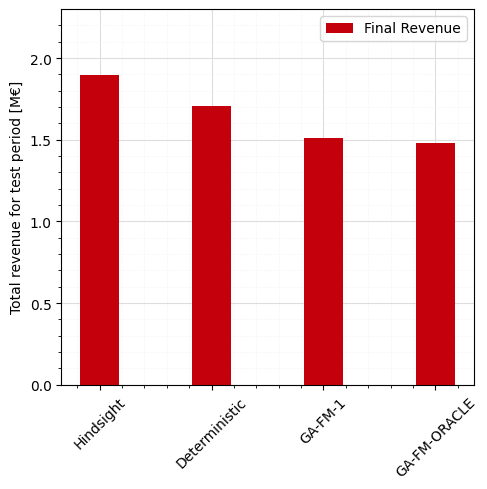

In [384]:
#-------------------PENALTY, ADJUSTMENT, AND ORACLE COMPARISON PLOTS----------------------
ga_res = results_g_fm[0]
ga_oracle_res = results_g_fm_oracle[0]
hapd_res = results_h_all_PD[11]
hapd_oracle_res = results_h_all_pd_ORACLE[0]
ha_res = results_h_rf[0]
ha_oracle_res = results_h_rf_oracle[0]

best_res = results_h_all_PD[11]

strict_det = True
plot_penalties = False
plot_adjustments = False


def result_plot():

    if strict_det:
        det_res = result_det_strict
    else:
        det_res = result_det



    xlabels = ["Hindsight", "Deterministic", "GA-FM-1", "GA-FM-ORACLE"]
    # xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12", "GA-AF-1"] 
    # xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12", "HAPD-AF-ORACLE"]
    # xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12", "HAPD-AF-12-OA"]

    values = np.array([
        np.sum(result_opt['obj']),
        np.sum(det_res['obj']),
        np.sum(ga_res['obj']),
        np.sum(ga_oracle_res['obj']),
        # obj(ha_oracle_res),
        # obj(best_res)
    ])

    # adjustments = np.array([
    #     0,
    #     np.sum(det_strict_up['obj'])-np.sum(det_res['obj']),
    #     np.sum(best_up['obj'])-np.sum(best_res['obj']),
    #     np.sum(result_opt_adj['obj'])-np.sum(best_res['obj']),
    # ])

    adjustments = np.array([
        0,
        np.sum(det_strict_up_dw['obj'])-np.sum(det_res['obj']),
        np.sum(best_up_dw['obj'])-np.sum(best_res['obj']),
        # obj(oracle_up_dw) - obj(hapd_oracle_res),
        np.sum(result_opt_adj['obj'])-np.sum(best_res['obj']),
    ])

    penalties = np.array([
        0,
        0,
        np.sum(best_res['missing_production'])*penalty,
        # obj(oracle_up_dw) - obj(hapd_oracle_res),
        np.sum(results_g_all[0]['missing_production'])*penalty,
    ])



    values *= 1/1e6
    adjustments *= 1/1e6
    penalties *= 1/1e6

    xs = range(len(values))
    width = 0.35
    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.bar(xs, values, width, color=red, label="Final Revenue")
    if plot_penalties:
        ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
    if plot_adjustments:
        ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xticks(xs)
    ax.set_ylabel("Total revenue for test period [M€]")
    ax.set_ylim(0, 2.3)
    fig.show()
    fig.tight_layout()
    ax.legend()

    return fig, ax

fig, ax = result_plot()
# fig.savefig("./pdfs/eval_GA.pdf")
# fig.savefig("./pdfs/eval_HAPD.pdf")
# fig.savefig("./pdfs/adj_up_HAPD.pdf")
# fig.savefig("./pdfs/adj_dw_HAPD.pdf")
# fig.savefig("./pdfs/adj_opt.pdf")
# fig.savefig("./pdfs/adj_comparison.pdf")
# fig.savefig("./pdfs/eval_penalty.pdf")

In [304]:
#------------------Comparison of adjustment results
def obj(res):
    return np.sum(res['obj'])

oracle_up, oracle_up_dw, oracle_pp = adjust(hapd_oracle_res)

def print_adj_res_strings(deto, detn, learno, learnn, oraco, oracn, opt_res):
    print(f"det increased with {(obj(detn) - obj(deto)) / obj(deto) * 100:.2f} % - {(obj(detn) - obj(deto)):.2f} €")
    print(f"learned increased with {(obj(learnn) - obj(learno)) / obj(learno) * 100:.2f} %  - {(obj(learnn) - obj(learno)):.2f} €")
    print(f"oracle increased with {(obj(oracn) - obj(oraco)) / obj(oraco) * 100:.2f} %  - {(obj(oracn) - obj(oraco)):.2f} €")
    print(f"learned is {(obj(learnn) - obj(detn)) / obj(detn) * 100:.2f} % better than det")
    print(f"oracle is {(obj(oracn) - obj(learnn)) / obj(learnn) * 100:.2f} % better than learned")
    print(f"hindsight is {(obj(opt_res) - obj(learnn)) / obj(learnn) * 100:.2f} % better than learned")

print_adj_res_strings(
    result_det_strict, 
    det_strict_up_dw, 
    best_res,
    best_up_dw,
    hapd_oracle_res,
    oracle_up_dw,
    result_opt
    )

det increased with 7.73 % - 131968.86 €
learned increased with 1.58 %  - 28710.74 €
oracle increased with 0.86 %  - 15862.96 €
learned is 0.61 % better than det
oracle is 0.72 % better than learned
hindsight is 2.26 % better than learned


In [ ]:
#---------------Print some high-level summaries for a model
def print_bal_info(res):
    b = np.sum(res['up'])
    s = np.sum(res['dw'])
    e = np.sum([res['dw'][i]*prices_S[t] for i, t in enumerate(range(idx_start, idx_end))])
    p = np.sum([res['up'][i]*prices_B[t] for i, t in enumerate(range(idx_start, idx_end))])
    f = np.sum([res['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))])
    h = np.sum([res['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])
    o = np.sum(res['obj'])
    # print("Total: ", s-b)
    # print("Surplus settlements: ", s, f" ({s / (s+b)*100:.2f}) %")
    # print("Deficit settlements: ", b, f" ({b / (s+b)*100:.2f}) %")
    print("Sum €: ", e+p)
    print("Total €: ", e-p)
    print("Surplus settlements €: ", e, f" ({e / (e+p)*100:.2f}) %")
    print("Deficit settlements €: ", p, f" ({p / (e+p)*100:.2f}) %")
    print("% of rev: ", (e+p)/(o-(e-p))*100)
    print("forward €: ", f)
    print("hydrogen €: ", h)
    print("Obj: ", o)
    print("Should-be-obj: ", f+h+e-p)

                

# print("\nOptimal")
# print_bal_info(result_opt)
print("\nDeterministic")
print_bal_info(result_det_strict)
print("\nLearned")
print_bal_info(best_res)

## Price analysis

##### Formatting price data

In [101]:
years = [2019, 2020]
yearly_separated_prices = np.array([prices_F[:year], prices_F[year:]])
yearly_separated_prices_days = [[], []]

# Reformat prices to be an array of days
for idx_year, f_prices in enumerate(yearly_separated_prices):
    current_day = np.empty(24)
    for i, price in enumerate(f_prices):
        if i%24 == 0 and i != 0:
            yearly_separated_prices_days[idx_year].append(current_day)
            current_day = np.empty(24)
        current_day[i%24] = price
    yearly_separated_prices_days[idx_year].append(current_day)

# We now have yearly_separated_prices_days = [[365 days], [366 days]]

##### Plotting hourly mean prices

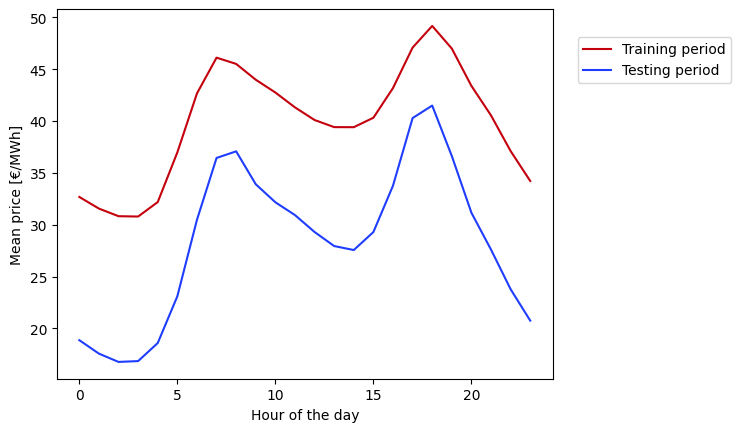

In [36]:

df_train = pd.DataFrame(yearly_separated_prices_days[0])
df_test = pd.DataFrame(yearly_separated_prices_days[1])
# lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1))

xs = range(24)
f = plt.figure()
plt.plot(xs, df_train.mean(), label="Training period", color=red)
plt.plot(xs, df_test.mean(), label="Testing period", color=blue)
plt.xlabel("Hour of the day")
plt.ylabel("Mean price [€/MWh]")
lgd = plt.legend(loc=(1.05,0.8))
# plt.grid()
# plt.tight_layout()
plt.show()
f.savefig('mean_prices.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


##### K-medoids clustering

In [155]:
#-------------K-medoids clustering--------------------
# Find k medoid days in each year
k = 2

# medoids is an array of depth (2(5(24)))
initial_medoids = [price_year[:k] for price_year in yearly_separated_prices_days]
final_medoids = []

for idx_period, f_prices in enumerate(yearly_separated_prices_days):
    data = np.array(yearly_separated_prices_days[idx_period])
    KMobj = KMedoids(n_clusters=k).fit(data)
    # labels = KMobj.labels_
    final_medoids.append(KMobj.cluster_centers_)



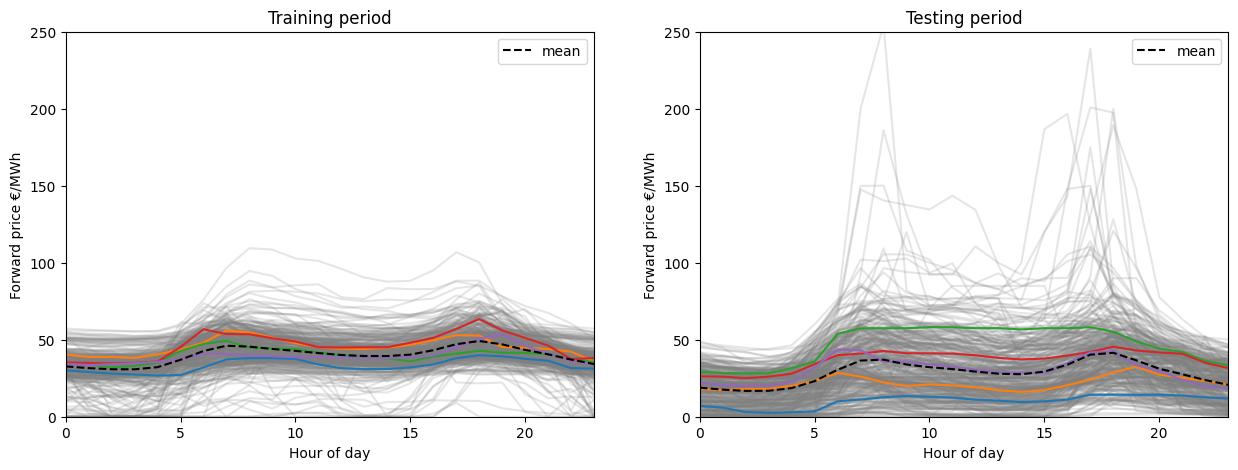

In [136]:
# ---------------Compare medoid days to each other
labels = ["Training period", "Testing period"]
dfs = [df_train, df_test]
## Plot for each year - good
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip(final_medoids, axs)):
    ax.set_ylim([0, 250])
    ax.set_xlim([0, 23])
    for p in yearly_separated_prices_days[idx]:
        ax.plot(range(24), p, "grey", alpha=0.2)
    for m in mlist:
        ax.plot(range(24), m)
    ax.plot(range(24), dfs[idx].mean(), 'k--', label="mean")
    ax.set_title(labels[idx])
    ax.set_ylabel("Forward price €/MWh")
    ax.set_xlabel("Hour of day")
    ax.legend()
plt.show()
# fig.savefig('k-medoids.pdf')


##### Wasserstein calculations

In [18]:
from scipy.stats import wasserstein_distance

v_test = np.array([20-i for i in range(10)])
u_test = np.array([i for i in range(10)])

dist_matrix = np.empty((3,5,5))

all_medoids = final_medoids

mean_dists = {
    "2019-2020": 0,
    "2019-2021": 0,
    "2020-2021": 0,
    "2020-2021-red": 0,
    "2019-2021-red": 0,
    "2021-2021-red": 0,
    "2019-2019": 0,
    "2020-2020": 0,
    "2021-2021": 0,
    "2021-red-2021-red": 0
}


years_list = [[0, 1], [0, 2], [1, 2], [1, 3], [0, 3], [2, 3], [0, 0], [1, 1], [2, 2], [3,3]]

for i, key in enumerate(mean_dists.keys()):
    for from_idx in range(5):
        for to_idx in range(5):
            mean_dists[key] += wasserstein_distance(all_medoids[years_list[i][0]][from_idx], all_medoids[years_list[i][1]][to_idx])


mean_dists

# for y_idx in range(3):
#     for i in range(len(yearly_separated_prices_days[years_list[y_idx][0]])):
#         for j in range(len(yearly_separated_prices_days[years_list[y_idx][1]])):
            

{'2019-2020': 377.6045833333334,
 '2019-2021': 1146.2787500000002,
 '2020-2021': 1432.2016666666666,
 '2020-2021-red': 425.37000000000006,
 '2019-2021-red': 396.9585833333333,
 '2021-2021-red': 1349.8748333333333,
 '2019-2019': 135.005,
 '2020-2020': 354.4383333333333,
 '2021-2021': 1089.595,
 '2021-red-2021-red': 435.8380000000001}

## Detailed analysis of model output

C:\Users\emilh\AppData\Local\Temp\ipykernel_6252\1212225967.py:50: FutureWarning: The input object of type 'Bbox' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Bbox', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)
C:\Users\emilh\AppData\Local\Temp\ipykernel_6252\1212225967.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


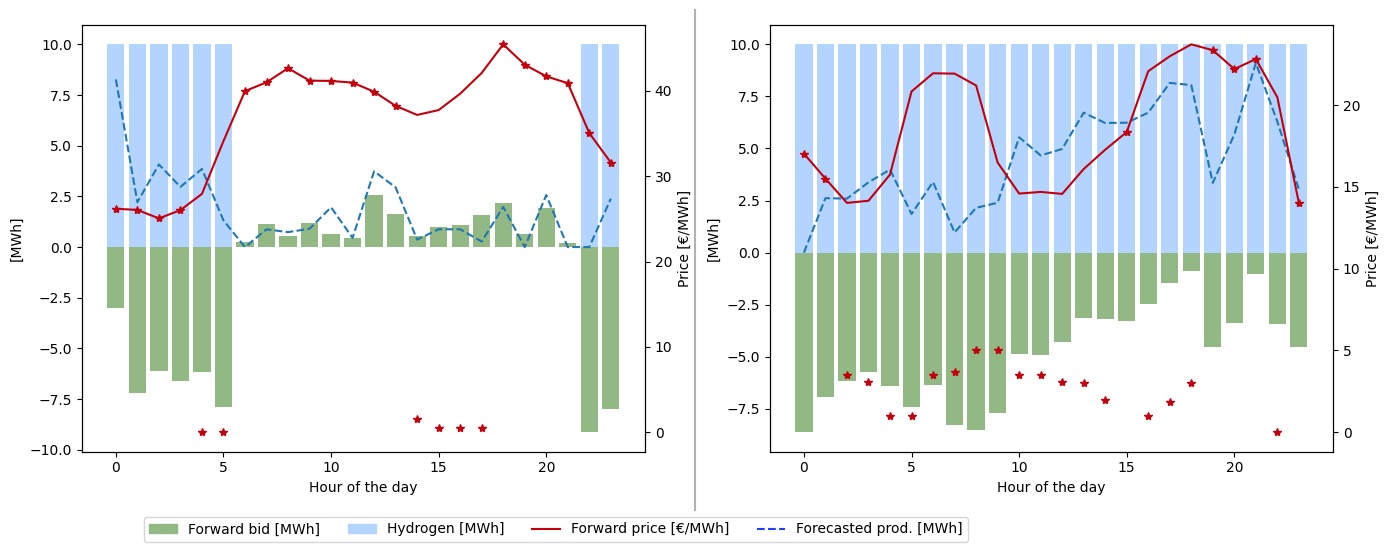

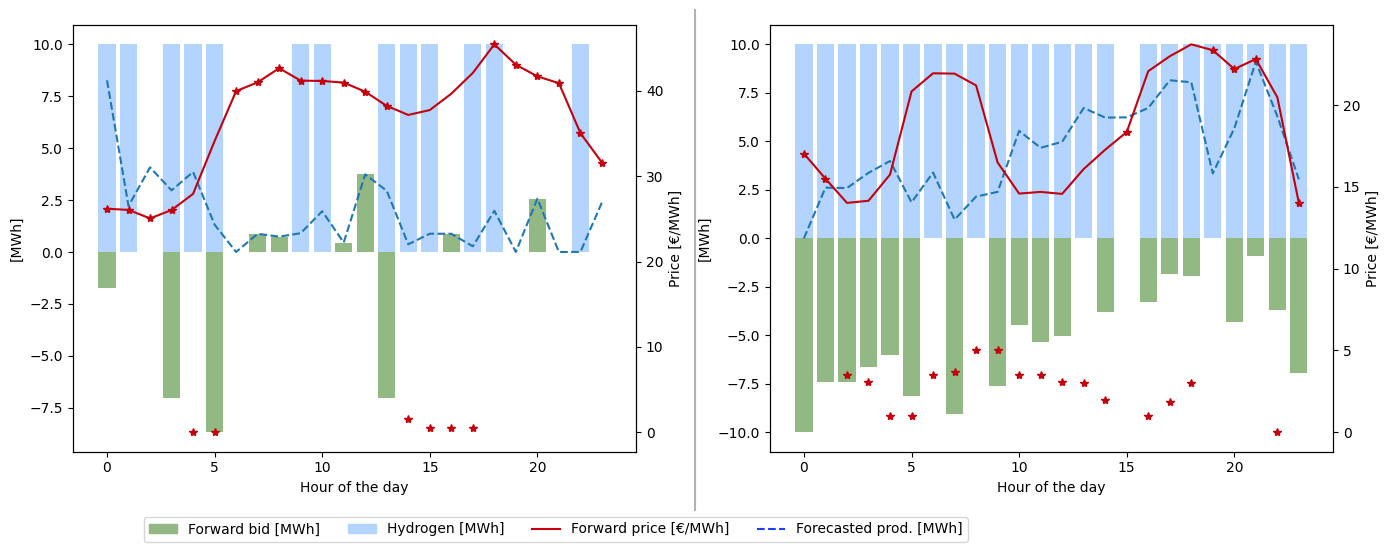

In [158]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.transforms as mtrans

offset = year
prices_F_test = prices_F[offset:]
prices_bal_test = [prices_B[offset+i] if round(prices_B[offset+i],0) < round(prices_F[offset+i],0) else prices_S[offset+i] for i in range(len(prices_S)-offset)]
prices_B_test = prices_B[offset:]
prices_S_test = prices_S[offset:]

def plot_res(res):
    fig, axs = plt.subplots(1,len(final_medoids[0]), figsize=(7*len(final_medoids[0]),5))
    handles = []
    fbid = mpatches.Patch(color=cgreen, label='Forward bid [MWh]')
    hydro = mpatches.Patch(color=cblue, label='Hydrogen [MWh]')
    fprice = Line2D([0], [0], label='Forward price [€/MWh]', color=red)
    fprod = Line2D([0], [0], label='Forecasted prod. [MWh]', color=blue)
    fprod.set_linestyle('--')
    handles.append(fbid) 
    handles.append(hydro) 
    handles.append(fprice) 
    handles.append(fprod) 
    for plotidx in range(len(final_medoids[0])):
        prods_learned = np.empty(24)
        forward_learned = np.empty(24)
        idx = KMobj.medoid_indices_[plotidx]*24
        for i, t in enumerate(range(idx, idx+24)):
            h = i%24
            prods_learned[h] = res['h_prod'][t]
            forward_learned[h] = res['forward_bid'][t]
        axs[plotidx].bar(range(24), prods_learned, label="Hydrogen", color=cblue)
        axs[plotidx].bar(range(24), forward_learned, label="Foward bid", color=cgreen)
        # axs[plotidx].plot(range(24), realized[offset+idx:offset+idx+24], 'r--', label="Realized prod.")
        axs[plotidx].plot(range(24), features.loc[offset+idx:offset+idx+23, "production_FC"]*10, '--', label="Forecasted prod.")
        ax2 = axs[plotidx].twinx()
        ax2.plot(range(24), prices_F_test[idx:idx+24], color=red, label="Forward price")
        # ax2.plot(range(24), prices_B_test[idx:idx+24], '*', color=red, label="Deficit price")
        # ax2.plot(range(24), prices_S_test[idx:idx+24], '*', color=red, label="Surplus price")
        ax2.plot(range(24), prices_bal_test[idx:idx+24], '*', color=red, label="Balancing price")
        # fig.tight_layout()
        ax2.set_ylabel("Price [€/MWh]")
        axs[plotidx].set_ylabel("[MWh]")
        axs[plotidx].set_xlabel("Hour of the day")
        # fig.legend(bbox_to_anchor=(1.25, 0.85))
    fig.legend(handles=handles, bbox_to_anchor=(0.7, 0), ncol=4)
    fig.tight_layout()
    # Get the bounding boxes of the axes including text decorations
    r = fig.canvas.get_renderer()
    get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
    bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)
    # Draw a horizontal lines at those coordinates
    for y in [1/len(final_medoids[0])*(i+1) for i in range(len(final_medoids[0])-1)]:
        line = plt.Line2D([y,y],[0,1], transform=fig.transFigure, color="grey", alpha=0.6)
        fig.add_artist(line)

    fig.show()

plot_res(best_res)
plot_res(result_det_strict)
# plot_res(result_opt)


## Production data analysis

##### Formatting production data

In [33]:
years = [2019, 2020, 2021]
yearly_separated_prods = np.array([realized[:8760], realized[8760:8760+8784], realized[8760+8784:]])
yearly_separated_prods_days = [[], [], []]

# Reformat prods to be an array of days
for idx_year, f_prods in enumerate(yearly_separated_prods):
    current_day = np.empty(24)
    for i, prod in enumerate(f_prods):
        if i%24 == 0 and i != 0:
            yearly_separated_prods_days[idx_year].append(current_day)
            current_day = np.empty(24)
        current_day[i%24] = prod
    yearly_separated_prods_days[idx_year].append(current_day)

# We now have yearly_separated_prods_days = [[365 days], [366 days], [365 days]]

C:\Users\emilh\AppData\Local\Temp\ipykernel_28472\3730098378.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  yearly_separated_prods = np.array([realized[:8760], realized[8760:8760+8784], realized[8760+8784:]])


##### K-medoids 

In [ ]:
#-------------K-medoids clustering--------------------
# Find k medoid days in each year
k = 6

# medoids is an array of depth (3(5(24)))
initial_medoids_prods = [prod_year[:k] for prod_year in yearly_separated_prods_days]
final_medoids_prods = []

for idx_year, f_prices in enumerate(yearly_separated_prods_days):
    data = np.array(yearly_separated_prods_days[idx_year])
    KMobj = KMedoids(n_clusters=k).fit(data)
    # labels = KMobj.labels_
    final_medoids_prods.append(KMobj.cluster_centers_)

##### Plotting results

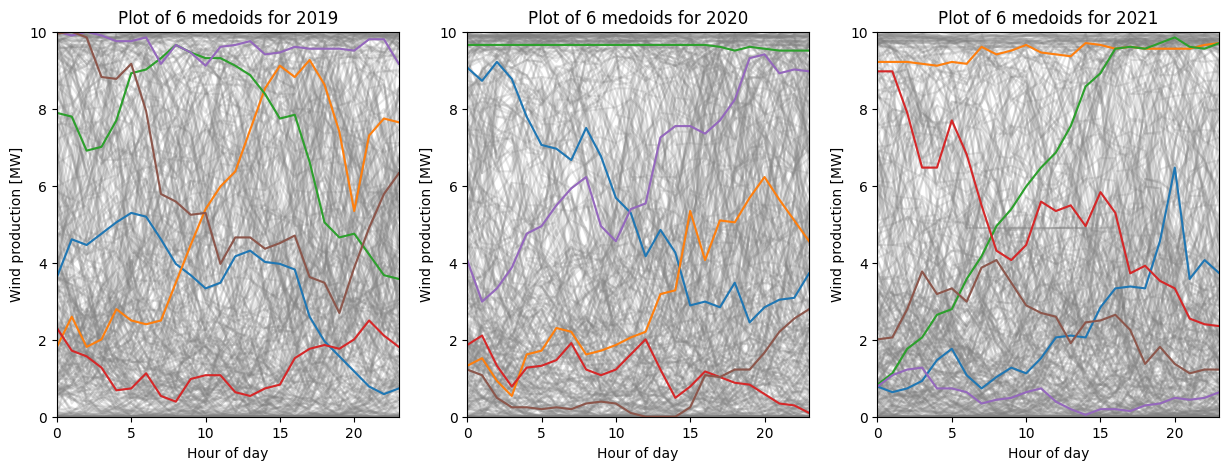

In [13]:
# ---------------Compare medoid days to each other
colors = ["green", "blue", "red"]
labels = ["2019", "2020", "2021"]

## Plot for each year - good
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip(final_medoids_prods, axs)):
    ax.set_ylim([0, 10])
    ax.set_xlim([0, 23])
    for p in yearly_separated_prods_days[idx]:
        ax.plot(range(24), p, "grey", alpha=0.2)
    for m in mlist:
        ax.plot(range(24), m)
    ax.set_title(f"Plot of {k} medoids for {labels[idx]}")
    ax.set_ylabel("Wind production [MW]")
    ax.set_xlabel("Hour of day")
plt.show()


In [ ]:

def plot_example_behavior():
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_fm = pd.read_csv("./results/x_fm.csv")
    x_fm1 = x_fm["x_fm1"][-year:].to_numpy()
    x_fm2 = x_fm["x_fm2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_fm1[i]
        hourly_x2[f"hour_{i%24}"] += x_fm2[i]

    hydrogen = np.zeros(24)
    adjustments = np.zeros(24)
    
    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)
            

    adjustments[2:4] = 10
    for i in range(5):
        hourly_prices[f"hour_{i}"] += 20

    for i in range(11, 15):
        
        hourly_prices[f"hour_{i}"] -= 20

    hydrogen[12:15] += 10
    hydrogen[-2:] += 10
    adjustments[-2:] = - 10
    prices = hourly_prices.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()

    prices_bal = np.array([hourly_prices[f"hour_{i}"] for i in range(24)])
    prices_bal[2:4] -= 50

    prices_bal[10:14] -= 4
    prices_bal[20] += 30
    prices_bal[23] += 40
    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    plt.plot(range(24), prices_bal, 'r', label="Balancing price")
    
    plt.bar(range(24), hydrogen, label="hydrogen production")
    plt.bar(range(24), adjustments, label="Adjustment")
    plt.legend()
    plt.title("Adjustment example")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    # print("Hydrogen prouction: ", np.sum(hydrogen))
plot_example_behavior()

In [ ]:

def plot_example_behavior_no_adj():
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_fm = pd.read_csv("./results/x_fm.csv")
    x_fm1 = x_fm["x_fm1"][-year:].to_numpy()
    x_fm2 = x_fm["x_fm2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_fm1[i]
        hourly_x2[f"hour_{i%24}"] += x_fm2[i]

    hydrogen = np.zeros(24)
    adjustments = np.zeros(24)
    
    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)
            

    adjustments[2:4] = 10
    for i in range(5):
        hourly_prices[f"hour_{i}"] += 20

    for i in range(11, 15):
        
        hourly_prices[f"hour_{i}"] -= 20

    hydrogen[12:15] += 10
    hydrogen[-2:] += 10
    adjustments[-2:] = - 10
    prices = hourly_prices.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()

    prices_bal = np.array([hourly_prices[f"hour_{i}"] for i in range(24)])
    prices_bal[2:4] -= 50

    prices_bal[10:14] += 30
    prices_bal[20] += 30
    prices_bal[23] += 40
    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    # plt.plot(range(24), prices_bal, 'r', label="Balancing price")
    
    plt.bar(range(24), hydrogen, label="hydrogen production")
    # plt.bar(range(24), adjustments, label="Adjustment")
    plt.legend()
    plt.title("Deterministic example")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    # print("Hydrogen prouction: ", np.sum(hydrogen))
plot_example_behavior_no_adj()

In [ ]:

def plot_deterministic_behavior():
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_fm = pd.read_csv("./results/x_fm.csv")
    x_fm1 = x_fm["x_fm1"][-year:].to_numpy()
    x_fm2 = x_fm["x_fm2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_fm1[i]
        hourly_x2[f"hour_{i%24}"] += x_fm2[i]

    hydrogen = np.zeros(24)
    
    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)
        if i < 5:
            hydrogen[i] += 10


    prices = hourly_prices.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()


    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    # plt.bar(range(24), forward, label="forward bid")
    plt.bar(range(24), hydrogen, label="hydrogen production")
    plt.legend()
    plt.title("Deterministic behavior")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    # print("Hydrogen prouction: ", np.sum(hydrogen))


plot_deterministic_behavior()

In [ ]:

def plot_mean_behavior(df_qs):
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_fm = pd.read_csv("./results/x_fm.csv")
    x_fm1 = x_fm["x_fm1"][-year:].to_numpy()
    x_fm2 = x_fm["x_fm2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_fm1[i]
        hourly_x2[f"hour_{i%24}"] += x_fm2[i]

    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)


    prices = hourly_prices.values()
    prods = hourly_prods.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()
    hydrogen = []
    forward = []
    for i, prod, price in zip(range(24), x1s, x2s):
        hydrogen.append(np.maximum((df_qs["qH1"][i]*prod + df_qs["qH2"][i]*price + df_qs["qH3"][i]),0))
        if (price > 35.2):
            forward.append(np.maximum((df_qs["qF1"][i]*prod + df_qs["qF2"][i]*price + df_qs["qF3"][i]),0))
        else:
            forward.append(0)

        # print(f'For hour {i}, FC={prod}, FP={price}, FB={(df_qs["qF1"][i]*prod + df_qs["qF2"][i]*price + df_qs["qF3"][i])}, H={(df_qs["qH1"][i]*prod + df_qs["qH2"][i]*price + df_qs["qH3"][i])}')
        

    balancing_price = np.array([hourly_prices[f"hour_{i}"] for i in range(24)])
    balancing_price[:5] += 35
    balancing_price[11:15] -= 20
    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    # plt.bar(range(24), forward, label="forward bid")
    plt.plot(range(24), balancing_price, 'r', label="balancing price")
    plt.bar(range(24), hydrogen, label="hydrogen production")
    plt.legend()
    plt.title("Learned behavior")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    print("Hydrogen prouction: ", np.sum(hydrogen))


df_initial = pd.read_csv("./results/RES_05.2_mo_24_5.csv")
plot_mean_behavior(df_initial)